## 1. Setup and Data Loading

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')

## 2. Load and Explore the Dataset

Dataset shape: (5110, 12)

Sample of the dataset:


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1



Data types:


id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object


Missing values:


id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


Unique values in BMI column:


array([36.6,  nan, 32.5, 34.4, 24. , 29. , 27.4, 22.8, 24.2, 29.7])


Target variable distribution:


stroke
0    95.127202
1     4.872798
Name: proportion, dtype: float64

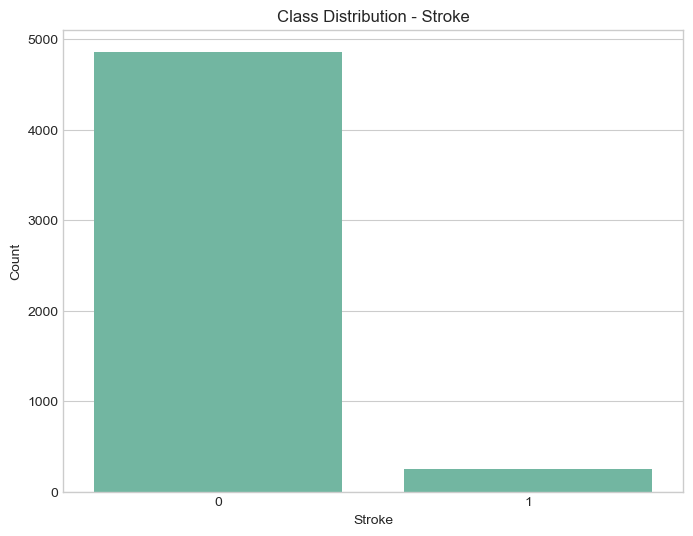

In [2]:
# Load the dataset
df = pd.read_csv('C://Users//Nikhil//Desktop/Stroke Prediction//healthcare-dataset-stroke-data.csv')

# Display basic information
print(f"Dataset shape: {df.shape}")
print("\nSample of the dataset:")
display(df.head())

# Check data types and missing values
print("\nData types:")
display(df.dtypes)

print("\nMissing values:")
display(df.isnull().sum())

# Check if 'N/A' strings are present in BMI column
print("\nUnique values in BMI column:")
display(df['bmi'].unique()[:10])  # Display first 10 unique values

# Convert 'N/A' strings to actual NaN values in BMI
df['bmi'] = pd.to_numeric(df['bmi'], errors='coerce')

# Check class distribution
print("\nTarget variable distribution:")
display(df['stroke'].value_counts(normalize=True) * 100)

# Visualize class imbalance
plt.figure(figsize=(8, 6))
sns.countplot(x='stroke', data=df)
plt.title('Class Distribution - Stroke')
plt.xlabel('Stroke')
plt.ylabel('Count')
plt.show()

## 3. Custom Transformers for Preprocessing

In [3]:
class BMIIndicatorExtractor(BaseEstimator, TransformerMixin):
    """Custom transformer to extract missing BMI indicator"""
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['missing_bmi'] = X_copy['bmi'].isna().astype(int)
        return X_copy

class AgeGroupTransformer(BaseEstimator, TransformerMixin):
    """Creates age groups based on statistical analysis"""
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['age_under_40'] = (X_copy['age'] < 40).astype(int)
        X_copy['age_40_to_60'] = ((X_copy['age'] >= 40) & (X_copy['age'] < 60)).astype(int)
        X_copy['age_over_60'] = (X_copy['age'] >= 60).astype(int)
        return X_copy

class GlucoseTransformer(BaseEstimator, TransformerMixin):
    """Creates glucose categories based on clinical thresholds"""
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['glucose_normal'] = (X_copy['avg_glucose_level'] < 100).astype(int)
        X_copy['glucose_prediabetic'] = ((X_copy['avg_glucose_level'] >= 100) & 
                                         (X_copy['avg_glucose_level'] <= 125)).astype(int)
        X_copy['glucose_diabetic'] = (X_copy['avg_glucose_level'] > 125).astype(int)
        return X_copy

class InteractionFeatureTransformer(BaseEstimator, TransformerMixin):
    """Creates interaction features between variables"""
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        # Age and medical conditions interactions
        X_copy['age_hypertension'] = X_copy['age'] * X_copy['hypertension']
        X_copy['age_heart_disease'] = X_copy['age'] * X_copy['heart_disease']
        
        # Medical conditions combined
        X_copy['comorbidity_count'] = X_copy['hypertension'] + X_copy['heart_disease']
        
        # Risk profile based on statistical analysis
        conditions = [
            (X_copy['age'] < 50) & (X_copy['hypertension'] == 0) & (X_copy['heart_disease'] == 0),
            ((X_copy['age'] >= 50) & (X_copy['age'] < 70) & (X_copy['hypertension'] == 0) & 
             (X_copy['heart_disease'] == 0)) | ((X_copy['age'] < 50) & 
                                              ((X_copy['hypertension'] == 1) | (X_copy['heart_disease'] == 1))),
            (X_copy['age'] >= 70) | ((X_copy['age'] >= 50) & (X_copy['age'] < 70) & 
                                    ((X_copy['hypertension'] == 1) | (X_copy['heart_disease'] == 1)))
        ]
        choices = [0, 1, 2]  # Low, Moderate, High risk
        X_copy['risk_profile'] = np.select(conditions, choices, default=1)
        return X_copy

## 4. Create Preprocessing Pipeline

In [4]:
def create_preprocessing_pipeline():
    """Creates the preprocessing pipeline for stroke prediction"""
    
    # Define column types
    numeric_features = ['age', 'avg_glucose_level', 'bmi']
    binary_features = ['hypertension', 'heart_disease']
    categorical_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
    
    # Handle BMI missing values and add indicator
    numeric_transformer = Pipeline(steps=[
        ('bmi_indicator', BMIIndicatorExtractor()),
        ('imputer', KNNImputer(n_neighbors=5)),
        ('scaler', StandardScaler())
    ])
    
    # Categorical variables transformer
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ])
    
    # Feature engineering transformers
    feature_engineering = Pipeline(steps=[
        ('age_groups', AgeGroupTransformer()),
        ('glucose_categories', GlucoseTransformer()),
        ('interactions', InteractionFeatureTransformer())
    ])
    
    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('bin', 'passthrough', binary_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )
    
    # Complete preprocessing pipeline
    preprocess_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('feature_engineering', feature_engineering)
    ])
    
    return preprocess_pipeline

## 5. Data Splitting and Preprocessing

In [5]:
# 5. Data Splitting and Preprocessing - Fixed Version

# Drop the ID column and prepare features and target
X = df.drop(['id', 'stroke'], axis=1)
y = df['stroke']

# Split data with stratification to maintain class imbalance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Define column types
numeric_features = ['age', 'avg_glucose_level', 'bmi']
binary_features = ['hypertension', 'heart_disease']
categorical_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

# Step 1: Handle missing values in BMI
# Create missing BMI indicator
missing_bmi_train = X_train['bmi'].isna().astype(int).values.reshape(-1, 1)
missing_bmi_test = X_test['bmi'].isna().astype(int).values.reshape(-1, 1)

# Step 2: Basic preprocessing
# Numeric features preprocessing
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

# Categorical variables transformer
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Combine basic preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('bin', 'passthrough', binary_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Apply basic preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Step 3: Manual feature engineering

# Create age group features
X_train_age = np.zeros((X_train.shape[0], 3))
X_train_age[:, 0] = (X_train['age'] < 40).astype(int)
X_train_age[:, 1] = ((X_train['age'] >= 40) & (X_train['age'] < 60)).astype(int)
X_train_age[:, 2] = (X_train['age'] >= 60).astype(int)

X_test_age = np.zeros((X_test.shape[0], 3))
X_test_age[:, 0] = (X_test['age'] < 40).astype(int)
X_test_age[:, 1] = ((X_test['age'] >= 40) & (X_test['age'] < 60)).astype(int)
X_test_age[:, 2] = (X_test['age'] >= 60).astype(int)

# Create glucose categories
X_train_glucose = np.zeros((X_train.shape[0], 3))
X_train_glucose[:, 0] = (X_train['avg_glucose_level'] < 100).astype(int)
X_train_glucose[:, 1] = ((X_train['avg_glucose_level'] >= 100) & (X_train['avg_glucose_level'] <= 125)).astype(int)
X_train_glucose[:, 2] = (X_train['avg_glucose_level'] > 125).astype(int)

X_test_glucose = np.zeros((X_test.shape[0], 3))
X_test_glucose[:, 0] = (X_test['avg_glucose_level'] < 100).astype(int)
X_test_glucose[:, 1] = ((X_test['avg_glucose_level'] >= 100) & (X_test['avg_glucose_level'] <= 125)).astype(int)
X_test_glucose[:, 2] = (X_test['avg_glucose_level'] > 125).astype(int)

# Create interaction features
X_train_interactions = np.zeros((X_train.shape[0], 3))
X_train_interactions[:, 0] = X_train['age'].values * X_train['hypertension'].values  # age_hypertension
X_train_interactions[:, 1] = X_train['age'].values * X_train['heart_disease'].values  # age_heart_disease
X_train_interactions[:, 2] = X_train['hypertension'].values + X_train['heart_disease'].values  # comorbidity count

X_test_interactions = np.zeros((X_test.shape[0], 3))
X_test_interactions[:, 0] = X_test['age'].values * X_test['hypertension'].values  # age_hypertension
X_test_interactions[:, 1] = X_test['age'].values * X_test['heart_disease'].values  # age_heart_disease
X_test_interactions[:, 2] = X_test['hypertension'].values + X_test['heart_disease'].values  # comorbidity count

# Create risk profile features
X_train_risk = np.zeros((X_train.shape[0], 1))
low_risk = (X_train['age'] < 50) & (X_train['hypertension'] == 0) & (X_train['heart_disease'] == 0)
high_risk = (X_train['age'] >= 70) | ((X_train['age'] >= 50) & (X_train['age'] < 70) & 
                                    ((X_train['hypertension'] == 1) | (X_train['heart_disease'] == 1)))
X_train_risk[:, 0] = np.select([low_risk, high_risk], [0, 2], default=1)

X_test_risk = np.zeros((X_test.shape[0], 1))
low_risk = (X_test['age'] < 50) & (X_test['hypertension'] == 0) & (X_test['heart_disease'] == 0)
high_risk = (X_test['age'] >= 70) | ((X_test['age'] >= 50) & (X_test['age'] < 70) & 
                                   ((X_test['hypertension'] == 1) | (X_test['heart_disease'] == 1)))
X_test_risk[:, 0] = np.select([low_risk, high_risk], [0, 2], default=1)

# Combine all features
X_train_enhanced = np.hstack((
    X_train_processed, 
    missing_bmi_train, 
    X_train_age, 
    X_train_glucose, 
    X_train_interactions,
    X_train_risk
))

X_test_enhanced = np.hstack((
    X_test_processed, 
    missing_bmi_test, 
    X_test_age, 
    X_test_glucose, 
    X_test_interactions,
    X_test_risk
))

# Display processed data shapes
print(f"Enhanced training data shape: {X_train_enhanced.shape}")
print(f"Enhanced test data shape: {X_test_enhanced.shape}")

Enhanced training data shape: (4088, 27)
Enhanced test data shape: (1022, 27)


## 6. Unsupervised Learning for Feature Enhancement

PCA explained variance ratio: [0.60373026 0.38628082 0.00306868]
Total variance explained: 0.9930797652493907

Stroke prevalence by cluster:


cluster
0     7.236842
1     3.377803
2    16.363636
3    17.098446
Name: stroke, dtype: float64

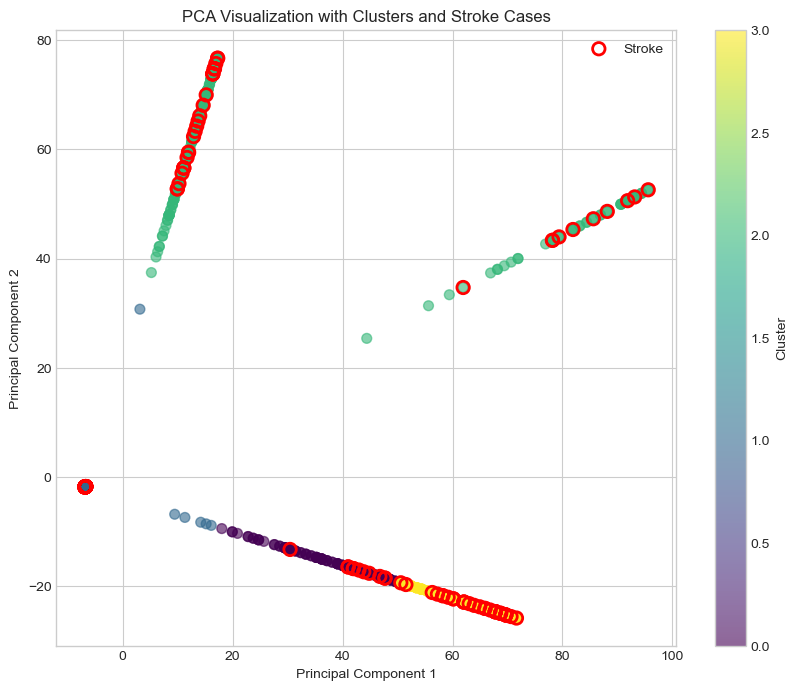

In [6]:
# Apply PCA to extract principal components
pca = PCA(n_components=3)
pca_features_train = pca.fit_transform(X_train_enhanced)
pca_features_test = pca.transform(X_test_enhanced)

# Display explained variance
print("PCA explained variance ratio:", pca.explained_variance_ratio_)
print("Total variance explained:", sum(pca.explained_variance_ratio_))

# Apply KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels_train = kmeans.fit_predict(X_train_enhanced)
cluster_labels_test = kmeans.predict(X_test_enhanced)

# Add PCA and cluster features to processed data
X_train_enhanced = np.hstack((
    X_train_enhanced, 
    pca_features_train, 
    cluster_labels_train.reshape(-1, 1)
))

X_test_enhanced = np.hstack((
    X_test_enhanced, 
    pca_features_test, 
    cluster_labels_test.reshape(-1, 1)
))

# Analyze stroke prevalence by cluster
cluster_stroke_analysis = pd.DataFrame({
    'cluster': cluster_labels_train,
    'stroke': y_train.values
})

print("\nStroke prevalence by cluster:")
display(cluster_stroke_analysis.groupby('cluster')['stroke'].mean() * 100)

# Visualize clusters and stroke occurrence
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    pca_features_train[:, 0], 
    pca_features_train[:, 1], 
    c=cluster_labels_train, 
    s=50, 
    alpha=0.6, 
    cmap='viridis'
)
plt.scatter(
    pca_features_train[y_train==1, 0], 
    pca_features_train[y_train==1, 1], 
    s=80, 
    facecolors='none', 
    edgecolors='red', 
    linewidth=2, 
    label='Stroke'
)
plt.title('PCA Visualization with Clusters and Stroke Cases')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.colorbar(scatter, label='Cluster')
plt.show()

## 7. Address Class Imbalance with SMOTE

In [7]:
# Apply SMOTE to the training data only
smote = SMOTE(random_state=42, sampling_strategy=0.5)  # Create a more balanced but not fully balanced dataset
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_enhanced, y_train)

print("Original class distribution:")
print(pd.Series(y_train).value_counts(normalize=True) * 100)

print("\nBalanced class distribution after SMOTE:")
print(pd.Series(y_train_balanced).value_counts(normalize=True) * 100)

Original class distribution:
stroke
0    95.132094
1     4.867906
Name: proportion, dtype: float64

Balanced class distribution after SMOTE:
stroke
0    66.672381
1    33.327619
Name: proportion, dtype: float64


## 8. Model Training and Evaluation


Logistic Regression Results:
ROC AUC: 0.8335
PR AUC: 0.2314

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.75      0.85       972
           1       0.14      0.78      0.24        50

    accuracy                           0.76      1022
   macro avg       0.56      0.77      0.55      1022
weighted avg       0.94      0.76      0.82      1022



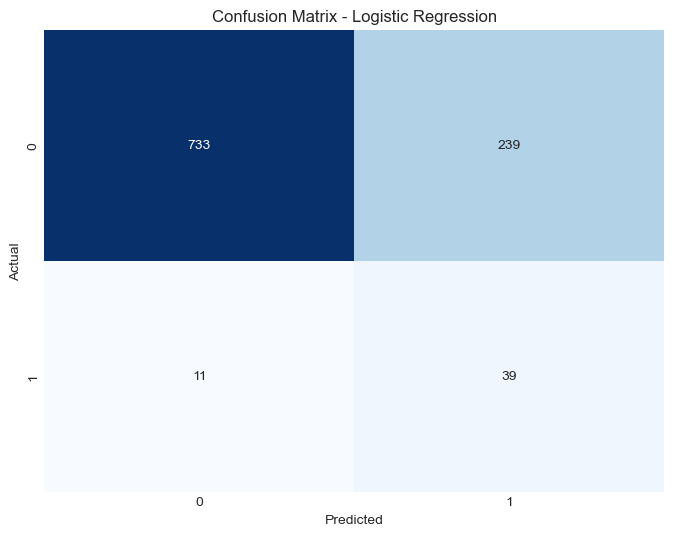

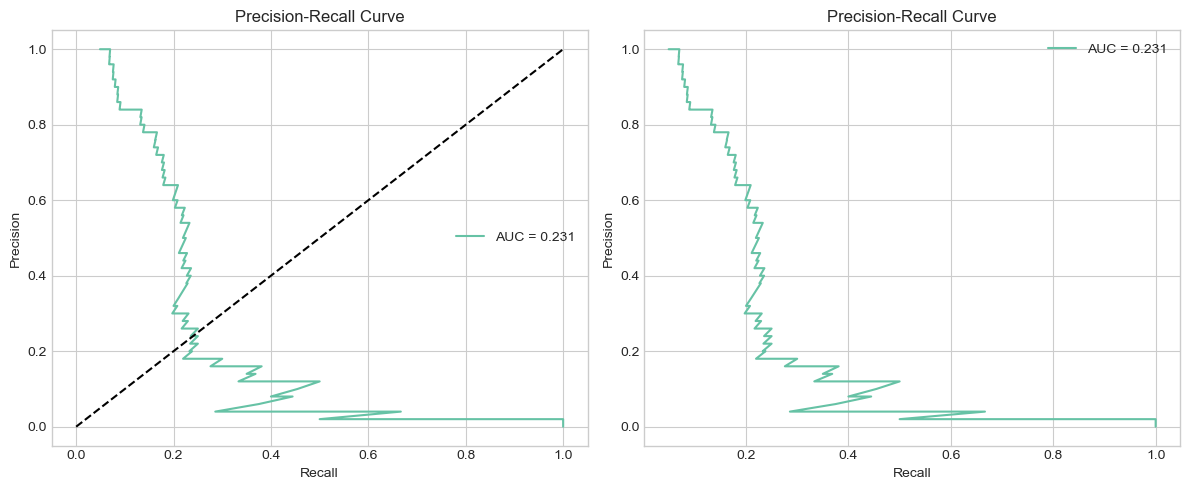


Random Forest Results:
ROC AUC: 0.7879
PR AUC: 0.1503

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       972
           1       0.16      0.06      0.09        50

    accuracy                           0.94      1022
   macro avg       0.56      0.52      0.53      1022
weighted avg       0.91      0.94      0.92      1022



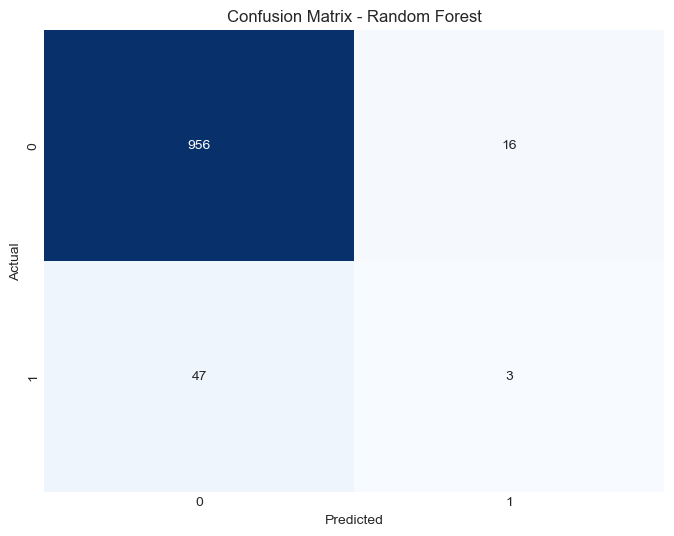

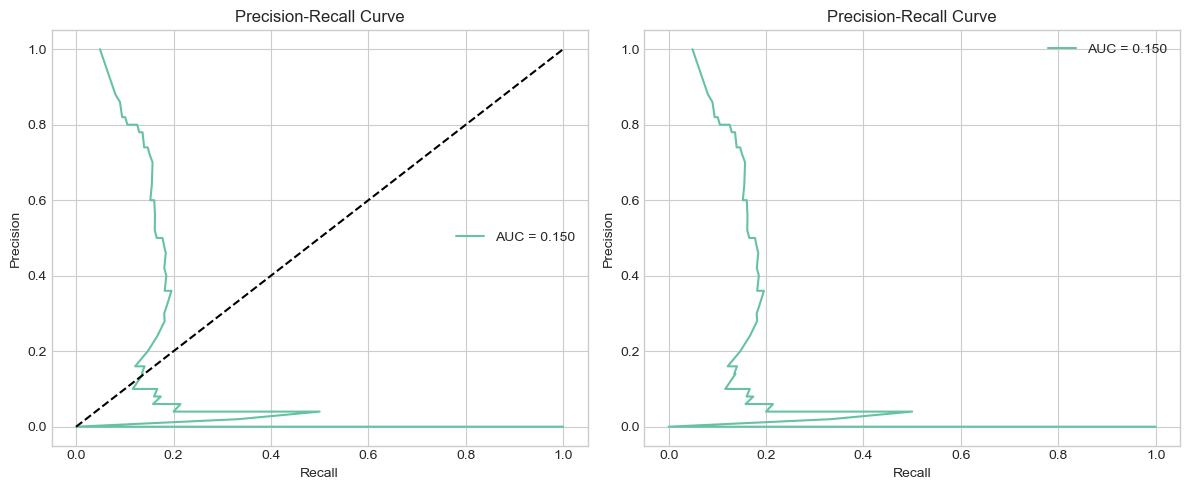


Gradient Boosting Results:
ROC AUC: 0.8134
PR AUC: 0.1721

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



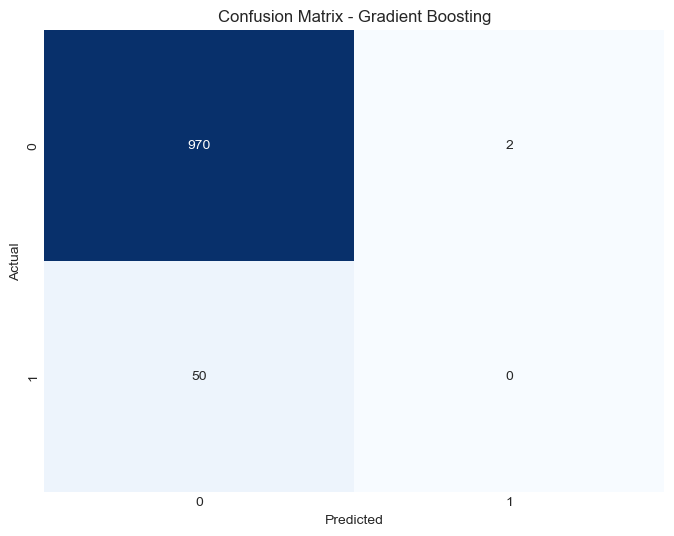

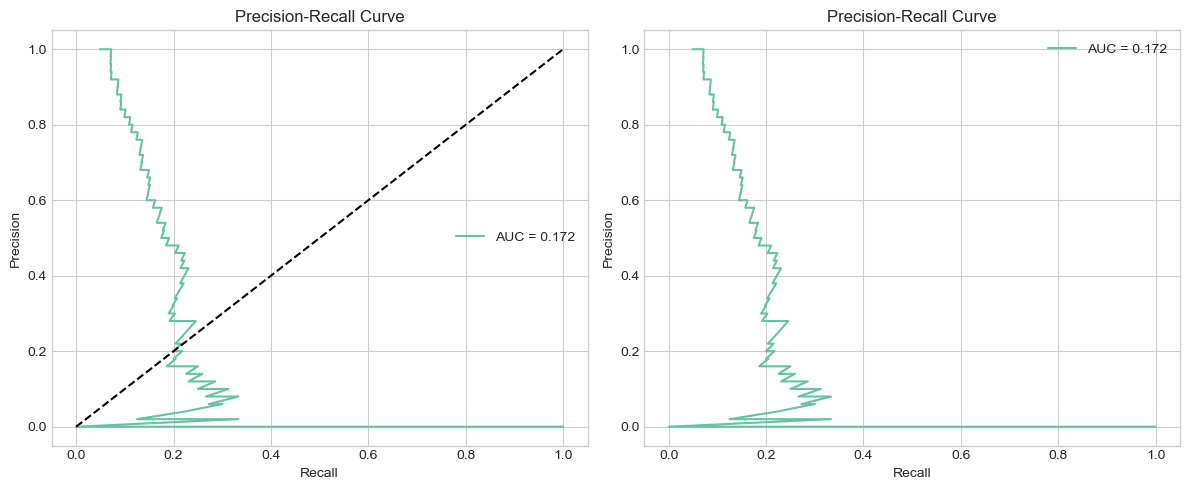

In [8]:
# Define models to evaluate
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Function to evaluate model performance
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Print results
    print(f"\n{model_name} Results:")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Plot ROC and PR curves
    plt.figure(figsize=(12, 5))
    
    # ROC curve
    plt.subplot(1, 2, 1)
    fpr, tpr, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'AUC = {pr_auc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    
    # PR curve
    plt.subplot(1, 2, 2)
    fpr, tpr, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'AUC = {pr_auc:.3f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    
    plt.tight_layout()
    plt.show()
    
    return model

# Train and evaluate each model
trained_models = {}
for name, model in models.items():
    trained_models[name] = evaluate_model(
        model, X_train_balanced, y_train_balanced, X_test_enhanced, y_test, name
    )

## 9. Feature Importance Analysis

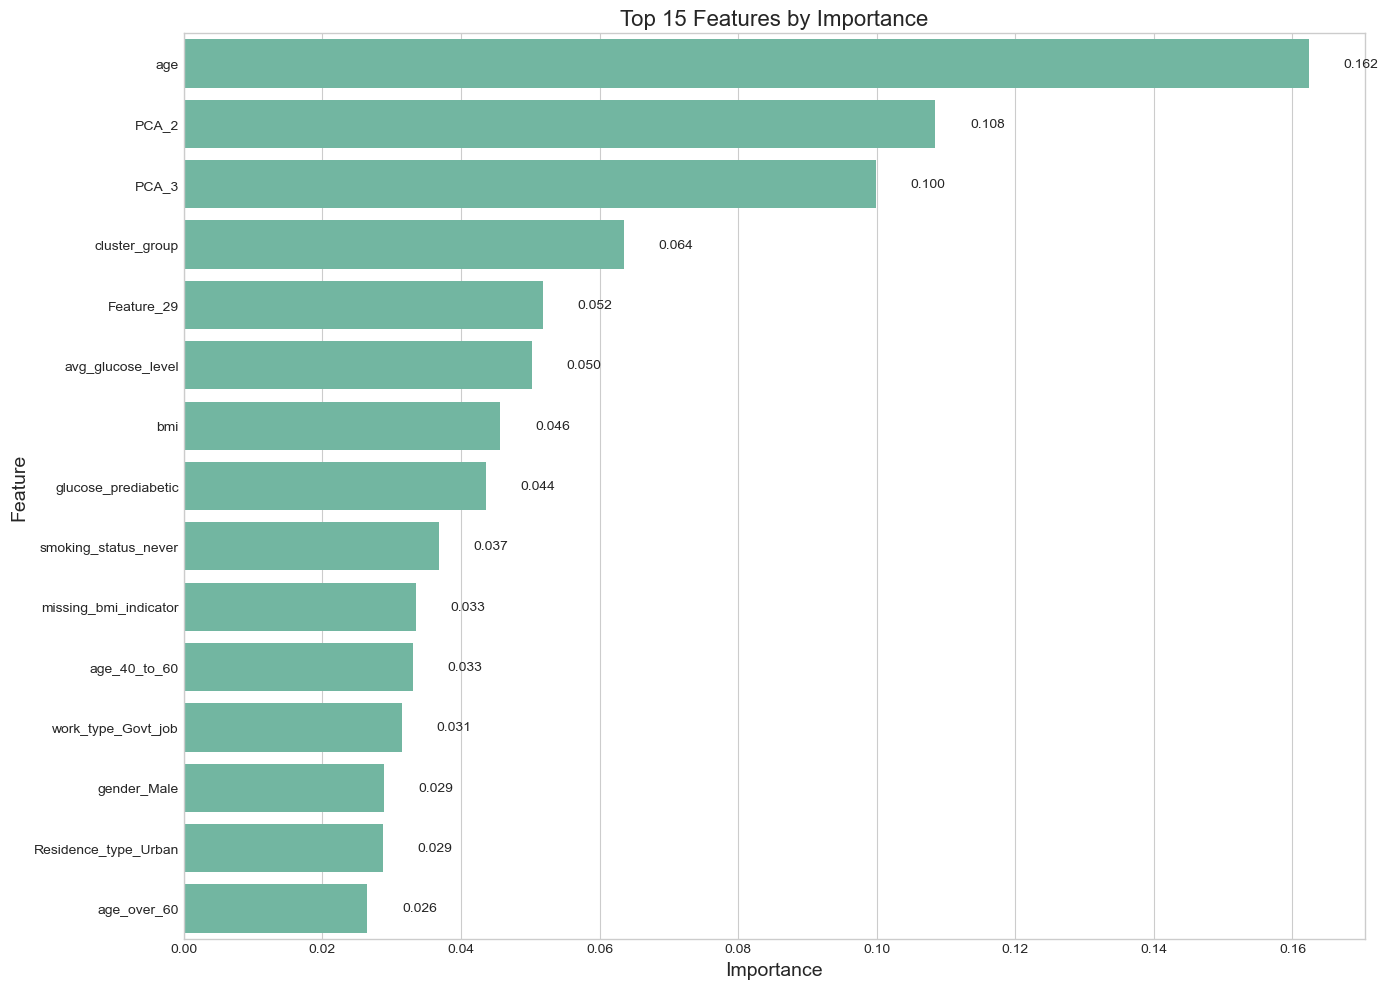

Feature Importance Ranking:


,Feature,Importance
0,age,0.162341
26,PCA_2,0.108449
27,PCA_3,0.099893
28,cluster_group,0.063541
29,Feature_29,0.051854
1,avg_glucose_level,0.050254
2,bmi,0.045676
19,glucose_prediabetic,0.043567
12,smoking_status_never,0.036786
14,missing_bmi_indicator,0.033451


In [9]:
# Get feature importance from the Random Forest model
if 'Random Forest' in trained_models:
    rf_model = trained_models['Random Forest']
    
    # Get the number of features used by the model
    n_features = rf_model.feature_importances_.shape[0]
    
    # Create generic feature names if we can't determine the exact names
    feature_names = [f"Feature_{i}" for i in range(n_features)]
    
    # Create more descriptive names for features we know
    feature_groups = [
        # Original numeric features (after scaling)
        ['age', 'avg_glucose_level', 'bmi'],
        
        # Binary features
        ['hypertension', 'heart_disease'],
        
        # One-hot encoded categorical features (estimate)
        ['gender_Male', 'ever_married_Yes', 
         'work_type_Private', 'work_type_Self-employed', 'work_type_Govt_job',
         'Residence_type_Urban', 
         'smoking_status_formerly', 'smoking_status_never', 'smoking_status_smokes'],
        
        # Engineered features
        ['missing_bmi_indicator',
         'age_under_40', 'age_40_to_60', 'age_over_60',
         'glucose_normal', 'glucose_prediabetic', 'glucose_diabetic',
         'age_hypertension', 'age_heart_disease', 'comorbidity_count',
         'risk_profile'],
        
        # If PCA and clustering were used
        ['PCA_1', 'PCA_2', 'PCA_3', 'cluster_group']
    ]
    
    # Flatten the feature group list
    descriptive_names = [name for group in feature_groups for name in group]
    
    # Use descriptive names where possible, or generic names otherwise
    final_names = (descriptive_names[:n_features] if len(descriptive_names) >= n_features 
                  else descriptive_names + feature_names[len(descriptive_names):])
    
    # Create feature importance dataframe
    feature_importances = pd.DataFrame({
        'Feature': final_names[:n_features],
        'Importance': rf_model.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    
    # Plot top 15 features
    plt.figure(figsize=(14, 10))
    ax = sns.barplot(x='Importance', y='Feature', data=feature_importances.head(15))
    plt.title('Top 15 Features by Importance', fontsize=16)
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    
    # Add value labels to the bars
    for i, v in enumerate(feature_importances.head(15)['Importance']):
        ax.text(v + 0.005, i, f"{v:.3f}", va='center')
    
    plt.tight_layout()
    plt.show()
    
    # Print the full feature importance table
    print("Feature Importance Ranking:")
    display(feature_importances.head(20))

## 10. Create Risk Scoring System

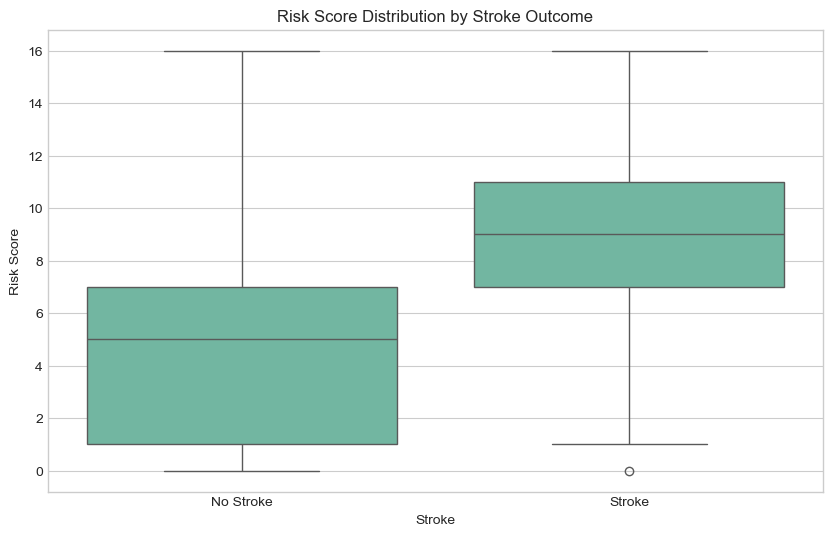

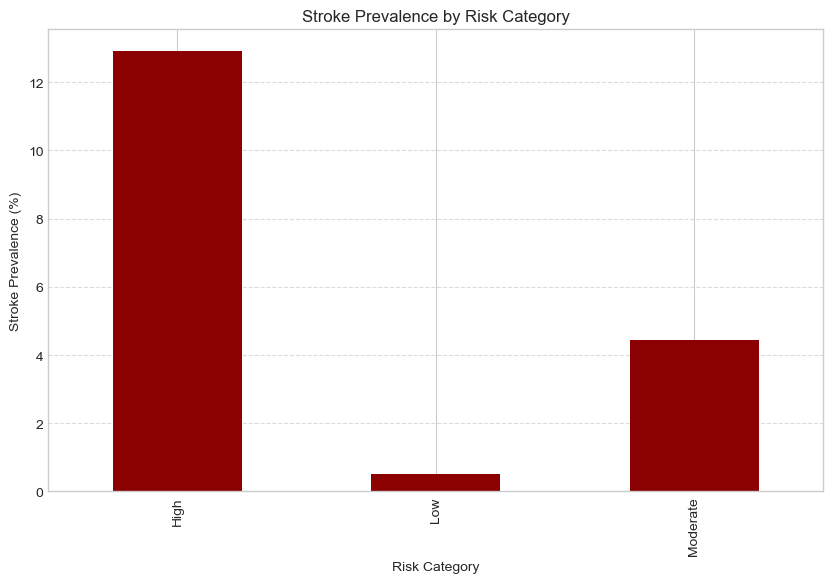

In [10]:
# Create a simplified risk scoring function based on key features
def stroke_risk_score(data):
    """Calculate stroke risk score based on key factors identified in analysis"""
    # Copy data to avoid modifying original
    data = data.copy()
    
    # Initialize score
    score = 0
    
    # Age (highest weight based on statistical analysis)
    if data['age'] < 40:
        score += 0
    elif 40 <= data['age'] < 60:
        score += 3
    else:  # age >= 60
        score += 6
    
    # Hypertension
    if data['hypertension'] == 1:
        score += 2
    
    # Heart disease (highest risk ratio in medical conditions)
    if data['heart_disease'] == 1:
        score += 3
    
    # Glucose level
    if data['avg_glucose_level'] < 100:
        score += 0
    elif 100 <= data['avg_glucose_level'] <= 125:
        score += 1
    else:  # diabetic range
        score += 2
    
    # BMI factor
    if pd.isna(data['bmi']):
        score += 2  # Missing BMI associated with higher risk
    elif data['bmi'] < 25:
        score += 0
    elif 25 <= data['bmi'] < 30:
        score += 1
    else:  # BMI >= 30
        score += 1
    
    # Ever married (slight risk increase)
    if data['ever_married'] == 'Yes':
        score += 1
    
    # Return score and risk category
    risk_category = 'Low'
    if score >= 5:
        risk_category = 'Moderate'
    if score >= 8:
        risk_category = 'High'
    
    return score, risk_category

# Apply risk scoring to the original dataset
df['risk_score'], df['risk_category'] = zip(*df.apply(stroke_risk_score, axis=1))

# Analyze risk score distribution by stroke outcome
plt.figure(figsize=(10, 6))
sns.boxplot(x='stroke', y='risk_score', data=df)
plt.title('Risk Score Distribution by Stroke Outcome')
plt.xlabel('Stroke')
plt.ylabel('Risk Score')
plt.xticks([0, 1], ['No Stroke', 'Stroke'])
plt.show()

# Plot risk category distribution by stroke outcome
risk_stroke = pd.crosstab(df['risk_category'], df['stroke'], normalize='index') * 100
risk_stroke.columns = ['No Stroke', 'Stroke']

plt.figure(figsize=(10, 6))
risk_stroke['Stroke'].plot(kind='bar', color='darkred')
plt.title('Stroke Prevalence by Risk Category')
plt.xlabel('Risk Category')
plt.ylabel('Stroke Prevalence (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 11. Complete Model Pipeline for New Data Prediction

In [11]:
def create_prediction_pipeline():
    """Create a complete pipeline for new data prediction"""
    # Preprocessing pipeline
    preprocess_pipeline = create_preprocessing_pipeline()
    
    # Include unsupervised learning components
    pca = PCA(n_components=3)
    kmeans = KMeans(n_clusters=4, random_state=42)
    
    # Use the best model (adjust this based on evaluation results)
    best_model = GradientBoostingClassifier(random_state=42)
    
    # Create a function to make predictions on new data
    def predict_stroke_risk(new_data):
        # Preprocess data
        processed_data = preprocess_pipeline.transform(new_data)
        
        # Apply PCA
        pca_features = pca.transform(processed_data)
        
        # Apply clustering
        cluster_labels = kmeans.predict(processed_data)
        
        # Combine features
        enhanced_data = np.hstack((
            processed_data,
            pca_features,
            cluster_labels.reshape(-1, 1)
        ))
        
        # Make predictions
        stroke_prob = best_model.predict_proba(enhanced_data)[:, 1]
        
        # Add risk scores
        new_data['risk_score'], new_data['risk_category'] = zip(*new_data.apply(
            stroke_risk_score, axis=1
        ))
        
        # Return predictions and risk information
        result = new_data.copy()
        result['stroke_probability'] = stroke_prob
        
        return result
    
    return predict_stroke_risk

# To use the prediction pipeline on new data:
# prediction_pipeline = create_prediction_pipeline()
# predictions = prediction_pipeline(new_patient_data)

## 12. Save the Trained Model and Preprocessing Components

In [12]:
import pickle
import os
import joblib

# Create a directory for saving model artifacts
if not os.path.exists('model'):
    os.makedirs('model')

# let's use the GradientBoostingClassifier as the best model
best_model = trained_models['Gradient Boosting']

# Save the trained model
joblib.dump(best_model, 'model/stroke_prediction_model.pkl')

# Save the preprocessing pipeline components
joblib.dump(preprocessor, 'model/preprocessor.pkl')

# Save PCA and KMeans models if used
joblib.dump(pca, 'model/pca.pkl')
joblib.dump(kmeans, 'model/kmeans.pkl')

# Create a dictionary with column information for future reference
column_info = {
    'numeric_features': ['age', 'avg_glucose_level', 'bmi'],
    'binary_features': ['hypertension', 'heart_disease'],
    'categorical_features': ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
}

# Save column information
with open('model/column_info.pkl', 'wb') as f:
    pickle.dump(column_info, f)

print("Model and preprocessing components saved successfully!")

Model and preprocessing components saved successfully!


## 13. Flask API Implementation

In [ ]:
from flask import Flask, request, jsonify
import numpy as np
import pandas as pd
import joblib
import pickle
import os

# Initialize Flask application
app = Flask(__name__)

# Load the saved model and preprocessing components
model = joblib.load('model/stroke_prediction_model.pkl')
preprocessor = joblib.load('model/preprocessor.pkl')
pca = joblib.load('model/pca.pkl')
kmeans = joblib.load('model/kmeans.pkl')

# Load column information
with open('model/column_info.pkl', 'rb') as f:
    column_info = pickle.load(f)

def preprocess_input(data):
    """
    Preprocess input data for prediction
    
    Parameters:
    -----------
    data : dict
        Dictionary containing patient information
    
    Returns:
    --------
    np.array
        Processed features ready for model prediction
    """
    # Convert input to DataFrame
    input_df = pd.DataFrame([data])
    
    # Extract column groups
    numeric_features = column_info['numeric_features']
    binary_features = column_info['binary_features']
    categorical_features = column_info['categorical_features']
    
    # Ensure all required columns are present
    required_columns = numeric_features + binary_features + categorical_features
    for col in required_columns:
        if col not in input_df.columns:
            input_df[col] = np.nan
    
    # Create missing BMI indicator
    missing_bmi = input_df['bmi'].isna().astype(int).values.reshape(-1, 1)
    
    # Apply preprocessor
    processed_data = preprocessor.transform(input_df)
    
    # Create age group features
    age_features = np.zeros((input_df.shape[0], 3))
    age_features[:, 0] = (input_df['age'] < 40).astype(int)
    age_features[:, 1] = ((input_df['age'] >= 40) & (input_df['age'] < 60)).astype(int)
    age_features[:, 2] = (input_df['age'] >= 60).astype(int)
    
    # Create glucose categories
    glucose_features = np.zeros((input_df.shape[0], 3))
    glucose_features[:, 0] = (input_df['avg_glucose_level'] < 100).astype(int)
    glucose_features[:, 1] = ((input_df['avg_glucose_level'] >= 100) & 
                              (input_df['avg_glucose_level'] <= 125)).astype(int)
    glucose_features[:, 2] = (input_df['avg_glucose_level'] > 125).astype(int)
    
    # Create interaction features
    interaction_features = np.zeros((input_df.shape[0], 3))
    interaction_features[:, 0] = input_df['age'].values * input_df['hypertension'].values
    interaction_features[:, 1] = input_df['age'].values * input_df['heart_disease'].values
    interaction_features[:, 2] = input_df['hypertension'].values + input_df['heart_disease'].values
    
    # Create risk profile features
    risk_features = np.zeros((input_df.shape[0], 1))
    low_risk = (input_df['age'] < 50) & (input_df['hypertension'] == 0) & (input_df['heart_disease'] == 0)
    high_risk = (input_df['age'] >= 70) | ((input_df['age'] >= 50) & (input_df['age'] < 70) & 
                                        ((input_df['hypertension'] == 1) | (input_df['heart_disease'] == 1)))
    risk_features[:, 0] = np.select([low_risk, high_risk], [0, 2], default=1)
    
    # Apply PCA
    pca_features = pca.transform(processed_data)
    
    # Apply clustering
    cluster_features = kmeans.predict(processed_data).reshape(-1, 1)
    
    # Combine all features
    enhanced_data = np.hstack((
        processed_data,
        missing_bmi,
        age_features,
        glucose_features,
        interaction_features,
        risk_features,
        pca_features,
        cluster_features
    ))
    
    return enhanced_data

def calculate_risk_score(data):
    """Calculate stroke risk score based on key factors"""
    # Initialize score
    score = 0
    
    # Age (highest weight based on statistical analysis)
    if data['age'] < 40:
        score += 0
    elif 40 <= data['age'] < 60:
        score += 3
    else:  # age >= 60
        score += 6
    
    # Hypertension
    if data['hypertension'] == 1:
        score += 2
    
    # Heart disease (highest risk ratio in medical conditions)
    if data['heart_disease'] == 1:
        score += 3
    
    # Glucose level
    if data['avg_glucose_level'] < 100:
        score += 0
    elif 100 <= data['avg_glucose_level'] <= 125:
        score += 1
    else:  # diabetic range
        score += 2
    
    # BMI factor
    if pd.isna(data['bmi']):
        score += 2  # Missing BMI associated with higher risk
    elif data['bmi'] < 25:
        score += 0
    elif 25 <= data['bmi'] < 30:
        score += 1
    else:  # BMI >= 30
        score += 1
    
    # Ever married (slight risk increase)
    if data['ever_married'] == 'Yes':
        score += 1
    
    # Determine risk category
    risk_category = 'Low'
    if score >= 5:
        risk_category = 'Moderate'
    if score >= 8:
        risk_category = 'High'
    
    return score, risk_category

@app.route('/predict', methods=['POST'])
def predict():
    """API endpoint for stroke prediction"""
    try:
        # Get input data from request
        data = request.json
        
        # Preprocess input data
        processed_input = preprocess_input(data)
        
        # Make prediction
        stroke_probability = model.predict_proba(processed_input)[0, 1]
        stroke_prediction = int(stroke_probability >= 0.5)
        
        # Calculate risk score
        risk_score, risk_category = calculate_risk_score(data)
        
        # Prepare response
        response = {
            'stroke_prediction': stroke_prediction,
            'stroke_probability': float(stroke_probability),
            'risk_score': risk_score,
            'risk_category': risk_category,
            'key_factors': []
        }
        
        # Identify key risk factors
        if data['age'] >= 60:
            response['key_factors'].append('Advanced age')
        if data['hypertension'] == 1:
            response['key_factors'].append('Hypertension')
        if data['heart_disease'] == 1:
            response['key_factors'].append('Heart disease')
        if data['avg_glucose_level'] > 125:
            response['key_factors'].append('Elevated glucose level')
        
        return jsonify(response)
    
    except Exception as e:
        return jsonify({'error': str(e)}), 400

@app.route('/health', methods=['GET'])
def health_check():
    """Health check endpoint"""
    return jsonify({'status': 'healthy'})

if __name__ == '__main__':
    app.run(debug=True, host='0.0.0.0', port=5000)

# 14. Model Interpretation with SHAP: Stroke Prediction Analysis


--- Analysis for Logistic Regression Model ---



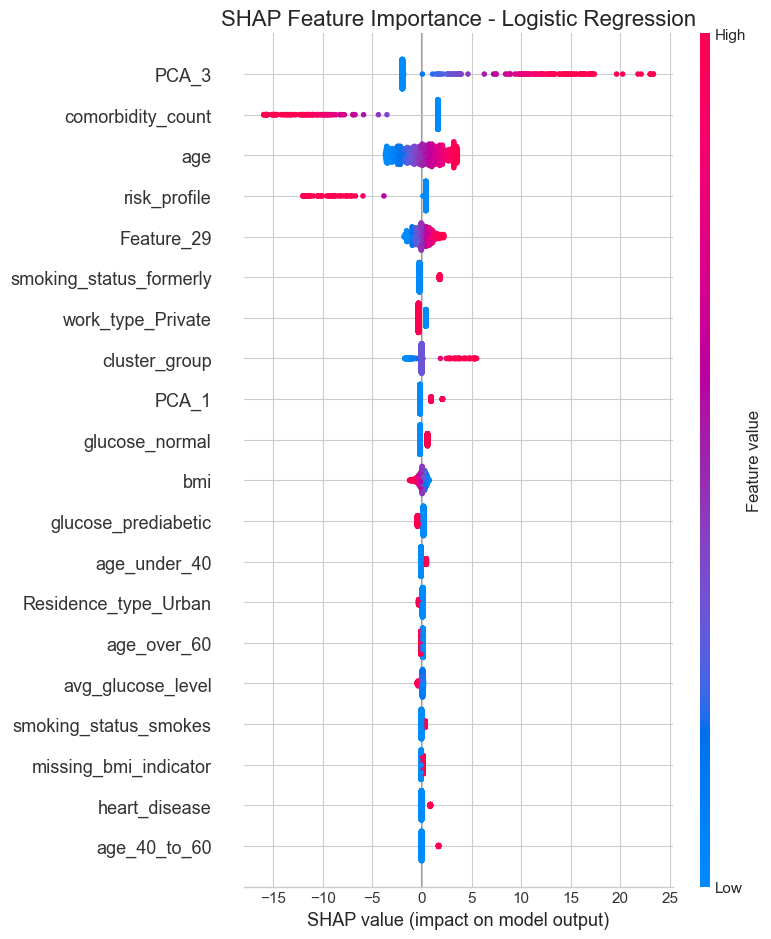

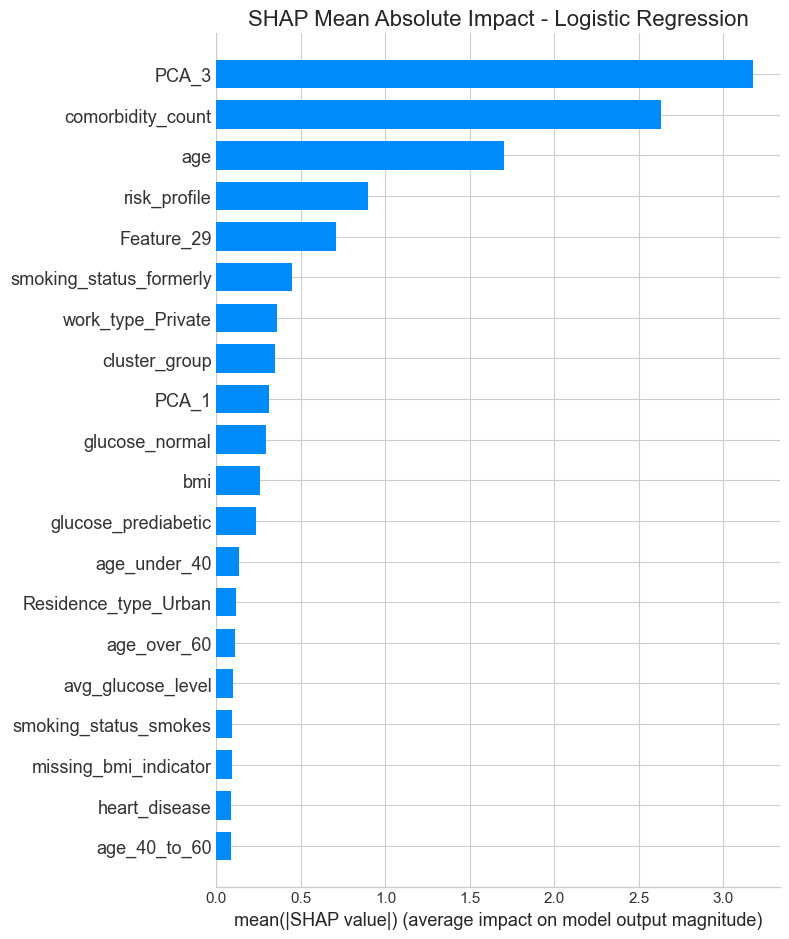

Top 10 Features by Importance:
                    Feature  Importance
27                    PCA_3    3.175832
23        comorbidity_count    2.632674
0                       age    1.702293
24             risk_profile    0.897873
29               Feature_29    0.704530
11  smoking_status_formerly    0.445510
7         work_type_Private    0.356817
28            cluster_group    0.344277
25                    PCA_1    0.311680
18           glucose_normal    0.291201

--- Analysis for Random Forest Model ---

Top 10 Features by Built-in Importance (Random Forest):
                 Feature  Importance
0                    age    0.162341
1                  PCA_2    0.108449
2                  PCA_3    0.099893
3          cluster_group    0.063541
4             Feature_29    0.051854
5      avg_glucose_level    0.050254
6                    bmi    0.045676
7    glucose_prediabetic    0.043567
8   smoking_status_never    0.036786
9  missing_bmi_indicator    0.033451


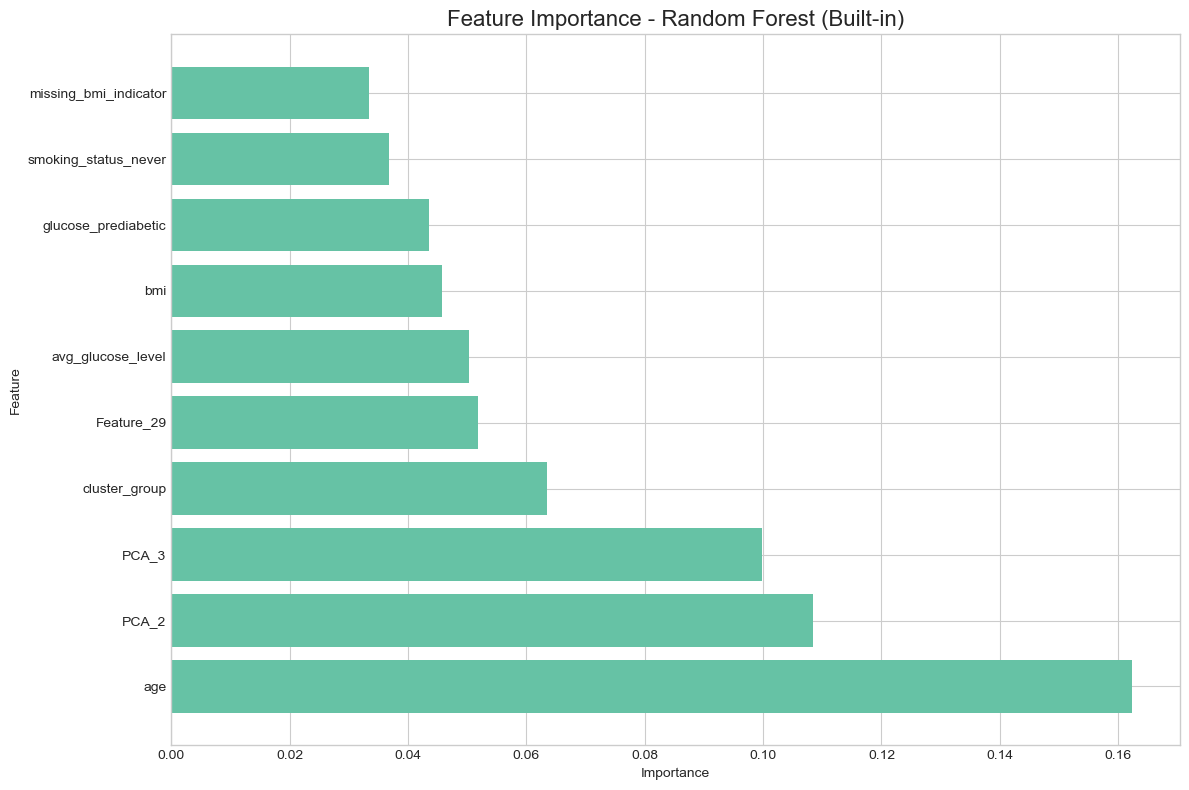

Calculating permutation importance (this may take a moment)...
Top 10 Features by Permutation Importance (Random Forest):
                    Feature  Importance
16             age_40_to_60    0.000978
4             heart_disease    0.000000
6          ever_married_Yes    0.000000
8   work_type_Self-employed    0.000000
21         age_hypertension    0.000000
11  smoking_status_formerly    0.000000
24             risk_profile   -0.000196
23        comorbidity_count   -0.000391
12     smoking_status_never   -0.000783
15             age_under_40   -0.001370


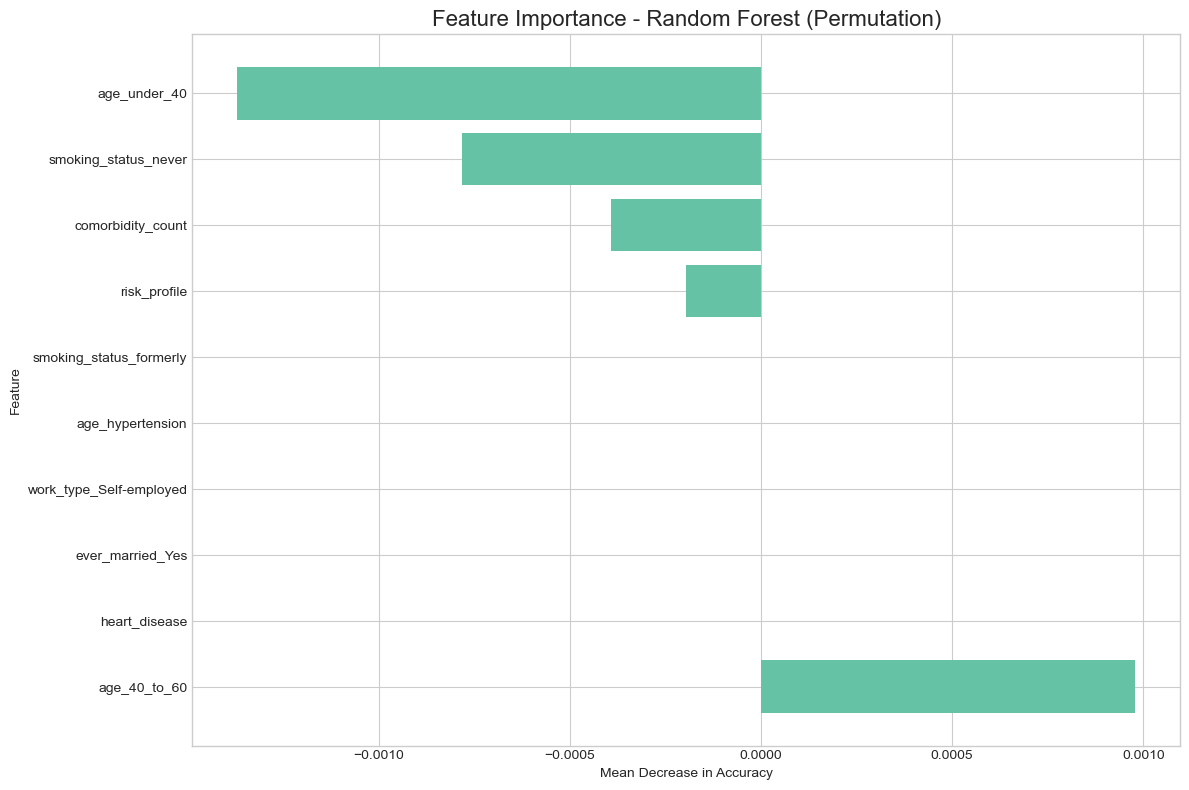


--- Analysis for Gradient Boosting Model ---

Top 10 Features by Built-in Importance (Gradient Boosting):
                 Feature  Importance
0                    age    0.346883
1   smoking_status_never    0.100654
2                  PCA_2    0.099872
3           age_40_to_60    0.086615
4     work_type_Govt_job    0.069438
5            gender_Male    0.063176
6  smoking_status_smokes    0.041594
7   Residence_type_Urban    0.032207
8           age_under_40    0.030504
9                  PCA_3    0.025555


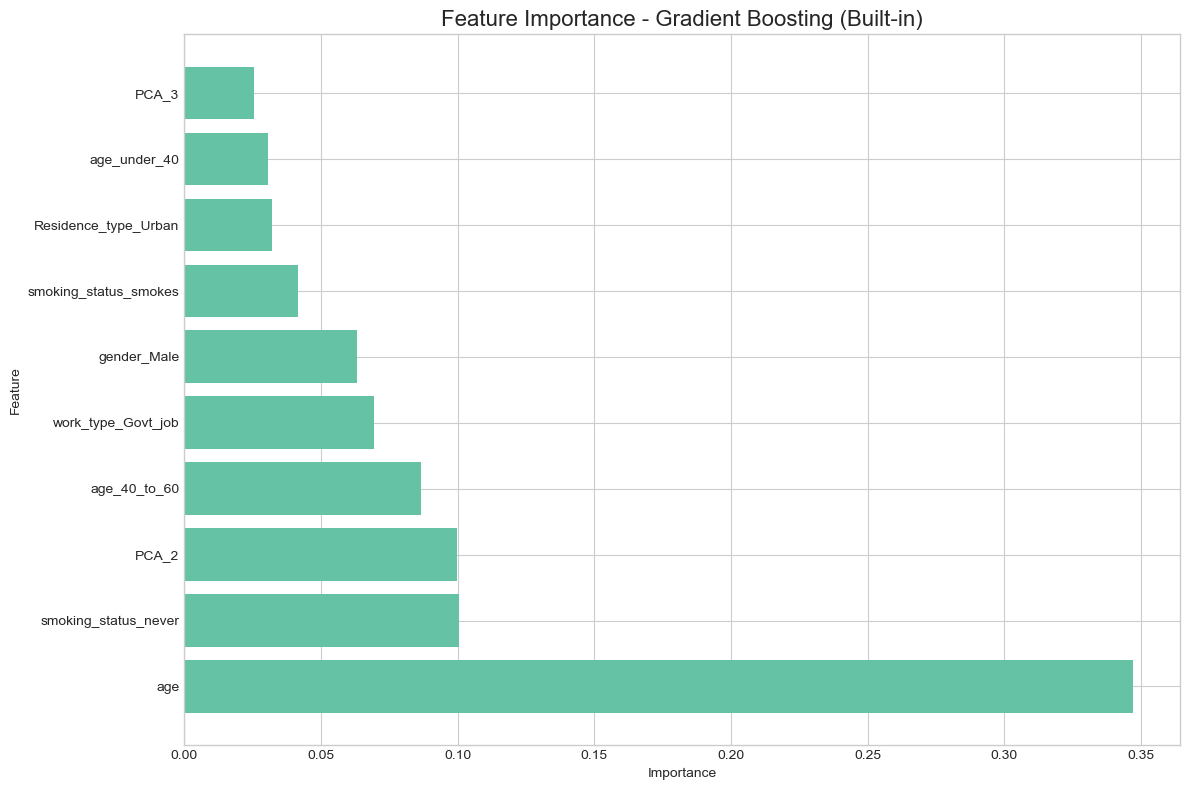

Calculating permutation importance (this may take a moment)...
Top 10 Features by Permutation Importance (Gradient Boosting):
                  Feature  Importance
0                     age    0.012720
27                  PCA_3    0.002348
28          cluster_group    0.001761
16           age_40_to_60    0.001761
18         glucose_normal    0.001566
1       avg_glucose_level    0.001566
26                  PCA_2    0.001174
2                     bmi    0.001174
20       glucose_diabetic    0.000978
14  missing_bmi_indicator    0.000978


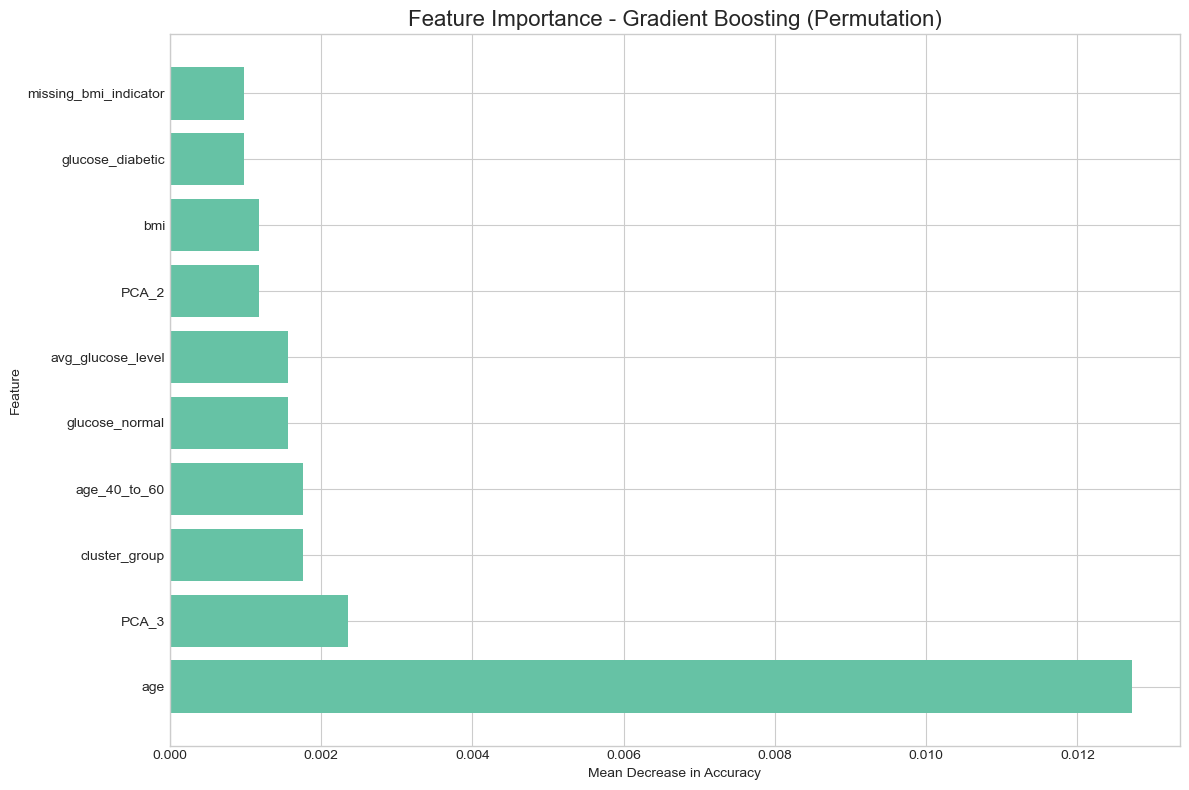


--- Comparing Feature Importance Across Models ---



<Figure size 1400x1000 with 0 Axes>

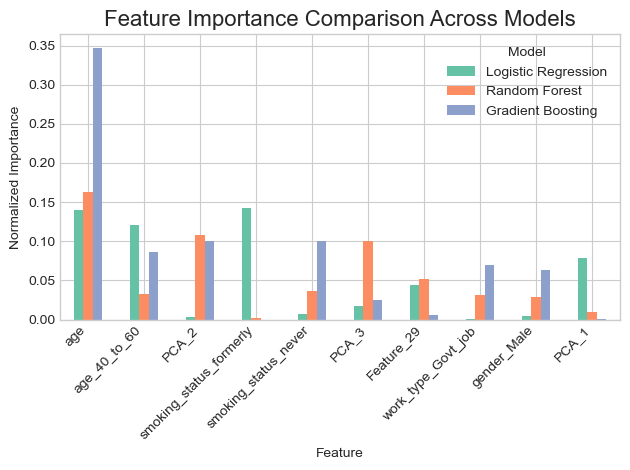

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.inspection import permutation_importance

# Function to create feature names list based on the model's feature count
def get_feature_names(n_features):
    """Generate feature names based on expected feature count"""
    base_features = [
        # Numeric features
        'age', 'avg_glucose_level', 'bmi',
        # Binary features
        'hypertension', 'heart_disease',
        # Categorical features (approximate)
        'gender_Male', 'ever_married_Yes', 
        'work_type_Private', 'work_type_Self-employed', 'work_type_Govt_job',
        'Residence_type_Urban',
        'smoking_status_formerly', 'smoking_status_never', 'smoking_status_smokes',
        # Engineered features
        'missing_bmi_indicator',
        'age_under_40', 'age_40_to_60', 'age_over_60',
        'glucose_normal', 'glucose_prediabetic', 'glucose_diabetic',
        'age_hypertension', 'age_heart_disease', 'comorbidity_count', 'risk_profile',
        # PCA and cluster features
        'PCA_1', 'PCA_2', 'PCA_3', 'cluster_group'
    ]
    
    # Adjust feature names to match the model's feature count
    if len(base_features) >= n_features:
        return base_features[:n_features]
    else:
        # Add generic names for any extra features
        extended_features = base_features.copy()
        for i in range(len(base_features), n_features):
            extended_features.append(f"Feature_{i}")
        return extended_features

# 1. Logistic Regression Analysis using SHAP
def analyze_logistic_regression(model, X_test, feature_count):
    print("\n--- Analysis for Logistic Regression Model ---\n")
    
    try:
        # Create SHAP explainer
        explainer = shap.LinearExplainer(model, X_test)
        shap_values = explainer.shap_values(X_test)
        
        # Get feature names
        feature_names = get_feature_names(feature_count)
        
        # SHAP summary plot
        plt.figure(figsize=(12, 10))
        shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)
        plt.title("SHAP Feature Importance - Logistic Regression", fontsize=16)
        plt.tight_layout()
        plt.show()
        
        # Feature importance bar plot
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="bar", show=False)
        plt.title("SHAP Mean Absolute Impact - Logistic Regression", fontsize=16)
        plt.tight_layout()
        plt.show()
        
        # Get feature importance
        feature_importance = np.abs(shap_values).mean(0)
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': feature_importance
        }).sort_values('Importance', ascending=False)
        
        print("Top 10 Features by Importance:")
        print(importance_df.head(10))
        
    except Exception as e:
        print(f"SHAP analysis failed with error: {str(e)}")
        
        # Fall back to model coefficients
        coef = model.coef_[0]
        feature_names = get_feature_names(len(coef))
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Coefficient': coef
        }).sort_values('Coefficient', ascending=False)
        
        print("Model coefficients (absolute values):")
        print(importance_df.head(10))
        
        # Plot coefficients
        plt.figure(figsize=(12, 8))
        plt.barh(importance_df['Feature'][:10], importance_df['Coefficient'][:10])
        plt.title("Logistic Regression Coefficients", fontsize=16)
        plt.xlabel("Coefficient Value")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.show()

# 2. Tree-based Models Analysis using built-in importance and permutation importance
def analyze_tree_model(model, X_train, X_test, y_test, model_name, feature_count):
    print(f"\n--- Analysis for {model_name} Model ---\n")
    
    # Get feature names
    feature_names = get_feature_names(feature_count)
    
    # Method 1: Built-in feature importance
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        indices = np.argsort(importance)[::-1]
        
        # Create importance dataframe
        importance_df = pd.DataFrame({
            'Feature': [feature_names[i] for i in indices],
            'Importance': [importance[i] for i in indices]
        })
        
        print(f"Top 10 Features by Built-in Importance ({model_name}):")
        print(importance_df.head(10))
        
        # Plot built-in importance
        plt.figure(figsize=(12, 8))
        plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10])
        plt.title(f"Feature Importance - {model_name} (Built-in)", fontsize=16)
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.show()
    
    # Method 2: Permutation importance (model-agnostic approach)
    try:
        print("Calculating permutation importance (this may take a moment)...")
        perm_importance = permutation_importance(
            model, X_test, y_test, 
            n_repeats=5, 
            random_state=42
        )
        
        # Create importance dataframe
        perm_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': perm_importance.importances_mean
        }).sort_values('Importance', ascending=False)
        
        print(f"Top 10 Features by Permutation Importance ({model_name}):")
        print(perm_importance_df.head(10))
        
        # Plot permutation importance
        plt.figure(figsize=(12, 8))
        plt.barh(perm_importance_df['Feature'][:10], perm_importance_df['Importance'][:10])
        plt.title(f"Feature Importance - {model_name} (Permutation)", fontsize=16)
        plt.xlabel("Mean Decrease in Accuracy")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.show()
    
    except Exception as e:
        print(f"Permutation importance calculation failed with error: {str(e)}")

# 3. Feature importance ranking comparison across models
def compare_model_importances(models, X_train, X_test, y_test):
    print("\n--- Comparing Feature Importance Across Models ---\n")
    
    # Dictionary to store importance rankings
    model_importances = {}
    
    # Process each model
    for name, model in models.items():
        # Get feature count
        if name == "Logistic Regression":
            feature_count = len(model.coef_[0])
        else:
            feature_count = len(model.feature_importances_)
        
        # Get feature names
        feature_names = get_feature_names(feature_count)
        
        # Get importance based on model type
        if name == "Logistic Regression":
            importance = np.abs(model.coef_[0])
        else:
            importance = model.feature_importances_
        
        # Store in dictionary
        model_importances[name] = pd.Series(importance, index=feature_names)
    
    # Create comparison dataframe
    comparison_df = pd.DataFrame(model_importances)
    
    # Normalize each column to sum to 1
    for column in comparison_df.columns:
        comparison_df[column] = comparison_df[column] / comparison_df[column].sum()
    
    # Plot comparison for top 10 features (based on average importance)
    comparison_df['Average'] = comparison_df.mean(axis=1)
    top_features = comparison_df.sort_values('Average', ascending=False).head(10).index
    
    # Plot
    plt.figure(figsize=(14, 10))
    comparison_df.loc[top_features].drop(columns=['Average']).plot(kind='bar')
    plt.title("Feature Importance Comparison Across Models", fontsize=16)
    plt.xlabel("Feature")
    plt.ylabel("Normalized Importance")
    plt.legend(title="Model")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return comparison_df

# Run analysis for each model
for name, model in trained_models.items():
    # Determine feature count
    if name == "Logistic Regression":
        feature_count = len(model.coef_[0])
        analyze_logistic_regression(model, X_test_enhanced, feature_count)
    else:
        feature_count = len(model.feature_importances_)
        analyze_tree_model(model, X_train_enhanced, X_test_enhanced, y_test, name, feature_count)

# Compare importance across all models
importance_comparison = compare_model_importances(trained_models, X_train_enhanced, X_test_enhanced, y_test)